- DGL 在 dgl.data 里实现了很多常用的图数据集。
- DGL 推荐用户将图数据处理为 dgl.data.DGLDataset 的子类

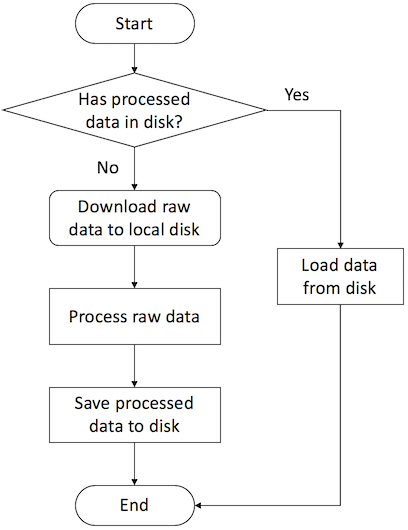


 MyDataset 它继承自 dgl.data.DGLDataset

In [1]:
from dgl.data import DGLDataset#a

In [ ]:
class MyDataset(DGLDataset):
      """ 用于在DGL中自定义图数据集的模板：

    Parameters
    ----------
    url : str
        下载原始数据集的url。
    raw_dir : str
        指定下载数据的存储目录或已下载数据的存储目录。默认: ~/.dgl/
    save_dir : str
        处理完成的数据集的保存目录。默认：raw_dir指定的值
    force_reload : bool
        是否重新导入数据集。默认：False
    verbose : bool
        是否打印进度信息。
    """
    def __init__(self,
                 url=None,
                 raw_dir=None,
                 save_dir=None,
                 force_reload=False,
                 verbose=False):
        super(MyDataset, self).__init__(name='dataset_name',
                                        url=url,
                                        raw_dir=raw_dir,
                                        save_dir=save_dir,
                                        force_reload=force_reload,
                                        verbose=verbose)
    def download(self):
         # 将原始数据下载到本地磁盘
        pass
    
    ########################下面的3个函数必须实现
    def process(self):
        # 将原始数据处理为图、标签和数据集划分的掩码
        pass

    def __getitem__(self, idx):
        # 通过idx得到与之对应的一个样本
        pass

    def __len__(self):
        # 数据样本的数量
        pass
     def save(self):
        # 将处理后的数据保存至 `self.save_path`
        pass

    def load(self):
        # 从 `self.save_path` 导入处理后的数据
        pass

    def has_cache(self):
        # 检查在 `self.save_path` 中是否存有处理后的数据
        pass

- process()
- __getitem__(idx)
-  __len__()
- 子类必须实现这些函数。

## 4.1 下载原始数据 download()

- 用户的数据集已经在本地磁盘中，请确保它被存放在目录 raw_dir 中
- 如果用户想在任何地方运行代码而又不想自己下载数据并将其移动到正确的目录中，则可以通过实现函数 download() 来自动完成。
- 如果文件是.gz、.tar、.tar.gz 或.tgz 文件，请使用 extract_archive() 函数进行解压缩。以下代码展示了如何在 BitcoinOTCDataset 类中下载一个.gz 文件：

In [ ]:
from dgl.data.utils import download, check_sha1

def download(self):
    # 存储文件的路径，请确保使用与原始文件名相同的后缀
    gz_file_path = os.path.join(self.raw_dir, self.name + '.csv.gz')
    # 下载文件
    download(self.url, path=gz_file_path)
    # 检查 SHA-1
    if not check_sha1(gz_file_path, self._sha1_str):
        raise UserWarning('File {} is downloaded but the content hash does not match.'
                          'The repo may be outdated or download may be incomplete. '
                          'Otherwise you can create an issue for it.'.format(self.name + '.csv.gz'))
    # 将文件解压缩到目录self.raw_dir下的self.name目录中
    self._extract_gz(gz_file_path, self.raw_path)

## 4.2 处理数据 process()

- 该函数假定原始数据已经位于 self.raw_dir 目录中。
- 图上的机器学习任务通常有三种类型：整图分类、节点分类和链接预测。

### 4.2.1  处理整图分类数据集

In [ ]:
from dgl.data import DGLDataset

class QM7bDataset(DGLDataset):
    _url = 'http://deepchem.io.s3-website-us-west-1.amazonaws.com/' \
           'datasets/qm7b.mat'
    _sha1_str = '4102c744bb9d6fd7b40ac67a300e49cd87e28392'

    def __init__(self, raw_dir=None, force_reload=False, verbose=False):
        super(QM7bDataset, self).__init__(name='qm7b',
                                          url=self._url,
                                          raw_dir=raw_dir,
                                          force_reload=force_reload,
                                          verbose=verbose)

    def process(self):
        mat_path = self.raw_path + '.mat'
        # 将数据处理为图列表和标签列表
        self.graphs, self.label = self._load_graph(mat_path)

    def __getitem__(self, idx):
        """ 通过idx获取对应的图和标签

        Parameters
        ----------
        idx : int
            Item index

        Returns
        -------
        (dgl.DGLGraph, Tensor)
        """
        return self.graphs[idx], self.label[idx]

    def __len__(self):
        """数据集中图的数量"""
        return len(self.graphs)

## 4.2.2处理节点分类数据集

- 整图分类不同，节点分类通常在单个图上进行。
- 集的划分是在图的节点集上进行。 
- DGL议使用节点掩码来指定数据集的划分。

- DGL 推荐重新排列图的节点 / 边，使得相邻节点 / 边的 ID 位于邻近区间内。(可以提高节点 / 边的邻居的局部性，为后续在图上进行的计算与分析的性能改善提供可能。)
- DGL 提供了名为 dgl.reorder_graph()

In [ ]:
from dgl.data import DGLBuiltinDataset
from dgl.data.utils import _get_dgl_url

class CitationGraphDataset(DGLBuiltinDataset):
    _urls = {
        'cora_v2' : 'dataset/cora_v2.zip',
        'citeseer' : 'dataset/citeseer.zip',
        'pubmed' : 'dataset/pubmed.zip',
    }

    def __init__(self, name, raw_dir=None, force_reload=False, verbose=True):
        assert name.lower() in ['cora', 'citeseer', 'pubmed']
        if name.lower() == 'cora':
            name = 'cora_v2'
        url = _get_dgl_url(self._urls[name])
        super(CitationGraphDataset, self).__init__(name,
                                                   url=url,
                                                   raw_dir=raw_dir,
                                                   force_reload=force_reload,
                                                   verbose=verbose)

    def process(self):
        # 跳过一些处理的代码
        # === 跳过数据处理 ===

        # 构建图
        g = dgl.graph(graph)

        # 划分掩码
        g.ndata['train_mask'] = train_mask
        g.ndata['val_mask'] = val_mask
        g.ndata['test_mask'] = test_mask

        # 节点的标签
        g.ndata['label'] = torch.tensor(labels)

        # 节点的特征
        g.ndata['feat'] = torch.tensor(_preprocess_features(features),
                                       dtype=F.data_type_dict['float32'])
        self._num_tasks = onehot_labels.shape[1]
        self._labels = labels
        # 重排图以获得更优的局部性
        self._g = dgl.reorder_graph(g)

    def __getitem__(self, idx):
        assert idx == 0, "这个数据集里只有一个图"
        return self._g

    def __len__(self):
        return 1
    
    
# 导入数据
dataset = CiteseerGraphDataset(raw_dir='')
graph = dataset[0]

# 获取划分的掩码
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']

# 获取节点特征
feats = graph.ndata['feat']

# 获取标签
labels = graph.ndata['label']

### 4.2.3 处理链接预测数据集

In [ ]:
# 创建链接预测数据集示例
class KnowledgeGraphDataset(DGLBuiltinDataset):
    def __init__(self, name, reverse=True, raw_dir=None, force_reload=False, verbose=True):
        self._name = name
        self.reverse = reverse
        url = _get_dgl_url('dataset/') + '{}.tgz'.format(name)
        super(KnowledgeGraphDataset, self).__init__(name,
                                                    url=url,
                                                    raw_dir=raw_dir,
                                                    force_reload=force_reload,
                                                    verbose=verbose)

    def process(self):
        # 跳过一些处理的代码
        # === 跳过数据处理 ===

        # 划分掩码
        g.edata['train_mask'] = train_mask
        g.edata['val_mask'] = val_mask
        g.edata['test_mask'] = test_mask

        # 边类型
        g.edata['etype'] = etype

        # 节点类型
        g.ndata['ntype'] = ntype
        self._g = g

    def __getitem__(self, idx):
        assert idx == 0, "这个数据集只有一个图"
        return self._g

    def __len__(self):
        return 1
    
from dgl.data import FB15k237Dataset

# 导入数据
dataset = FB15k237Dataset()
graph = dataset[0]

# 获取训练集掩码
train_mask = graph.edata['train_mask']
train_idx = torch.nonzero(train_mask, as_tuple=False).squeeze()
src, dst = graph.edges(train_idx)

# 获取训练集中的边类型
rel = graph.edata['etype'][train_idx]

##  4.3保存和加载数据

- dgl.save_graphs() 和 dgl.load_graphs(): 保存 DGLGraph 对象和标签到本地磁盘和从本地磁盘读取它们.
-  dgl.data.utils.save_info() 和 dgl.data.utils.load_info(): 将数据集的有用信息 (python dict 对象) 保存到本地磁盘和从本地磁盘读取它们。

In [ ]:
import os
from dgl import save_graphs, load_graphs
from dgl.data.utils import makedirs, save_info, load_info

def save(self):
    # 保存图和标签
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    save_graphs(graph_path, self.graphs, {'labels': self.labels})
    # 在Python字典里保存其他信息
    info_path = os.path.join(self.save_path, self.mode + '_info.pkl')
    save_info(info_path, {'num_classes': self.num_classes})

def load(self):
    # 从目录 `self.save_path` 里读取处理过的数据
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    self.graphs, label_dict = load_graphs(graph_path)
    self.labels = label_dict['labels']
    info_path = os.path.join(self.save_path, self.mode + '_info.pkl')
    self.num_classes = load_info(info_path)['num_classes']

def has_cache(self):
    # 检查在 `self.save_path` 里是否有处理过的数据文件
    graph_path = os.path.join(self.save_path, self.mode + '_dgl_graph.bin')
    info_path = os.path.join(self.save_path, self.mode + '_info.pkl')
    return os.path.exists(graph_path) and os.path.exists(info_path)

## 4.3 使用 ogb 包导入 OGB 数据集

- Open Graph Benchmark (OGB) 是一个图深度学习的基准数据集